In [1]:
import os
import torch
import itertools
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from typing import List, Tuple, Dict
from tqdm import tqdm
import random
from scipy.linalg import sqrtm

In [2]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [3]:
# Define a classe de transformação
class Transform:
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define a classe SeismicDataset para carregar dados binários
class SeismicDataset:
    def __init__(self, elastic_folder, acoustic_folder, shape=(256, 256, 1)):
        self.elastic_files = sorted([os.path.join(elastic_folder, f) for f in os.listdir(elastic_folder) if f.endswith('.bin')])
        self.acoustic_files = sorted([os.path.join(acoustic_folder, f) for f in os.listdir(acoustic_folder) if f.endswith('.bin')])
        self.transformer = Transform()

        # Define o tamanho dos patches com base no parâmetro `shape`
        self.patch_shape = shape

        # Verifica se o número de patches é o mesmo em ambas as pastas
        assert len(self.elastic_files) == len(self.acoustic_files), "Número de patches deve ser igual em ambas as pastas."

    def __len__(self):
        return len(self.elastic_files)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        # Carrega os patches binários para elastic e acoustic
        elastic_patch = np.fromfile(self.elastic_files[idx], dtype='float32').reshape(self.patch_shape)
        acoustic_patch = np.fromfile(self.acoustic_files[idx], dtype='float32').reshape(self.patch_shape)
        
        # Transforma para tensor
        elastic_patch = self.transformer(elastic_patch)
        acoustic_patch = self.transformer(acoustic_patch)

        return acoustic_patch, elastic_patch


# Define as pastas de treino e teste
train_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\elastic_vz'
train_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\acoustic'
test_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\elastic_vz'
test_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\acoustic'

# Cria o dataset e DataLoader para treino e teste
train_ds = SeismicDataset(train_elastic_path, train_acoustic_path, shape=(256, 256, 1))
test_ds = SeismicDataset(test_elastic_path, test_acoustic_path, shape=(768, 361, 1))

# Parâmetros do DataLoader
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_TEST = 1

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE_TEST, shuffle=False, drop_last=False)

print("DataLoaders de treino e teste criados com sucesso!")

DataLoaders de treino e teste criados com sucesso!


In [4]:
# Número total de patches no dataset de treino
num_train_patches = len(train_ds)
num_test_patches = len(test_ds)

# Número de batches no DataLoader
num_train_batches = len(train_dl)
num_test_batches = len(test_dl)

print(f"Número total de patches de treino: {num_train_patches}")
print(f"Número total de patches de teste: {num_test_patches}")
print(f"Número total de batches de treino: {num_train_batches}")
print(f"Número total de batches de teste: {num_test_batches}")

Número total de patches de treino: 3000
Número total de patches de teste: 61
Número total de batches de treino: 750
Número total de batches de teste: 61


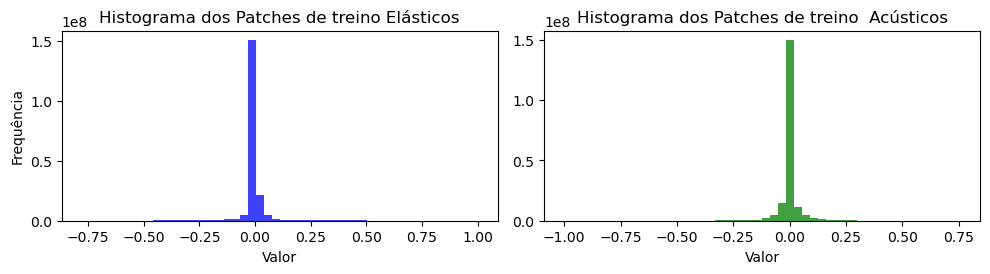

In [5]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in train_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de treino Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de treino  Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

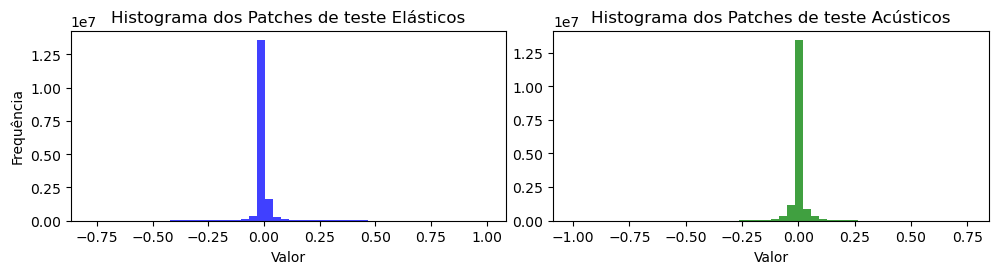

In [6]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in test_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

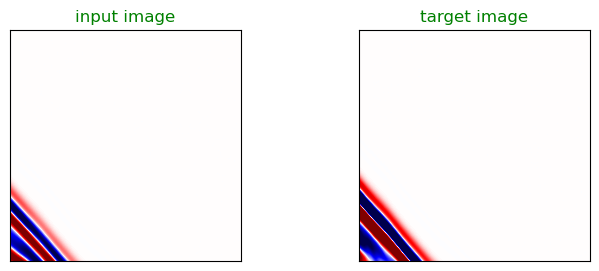

In [7]:
def show_img_sample(train_dl):
    for i, (real_input, real_target) in enumerate(train_dl):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_input[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_input[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("input image", c="g")
        ax[1].imshow(real_target[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("target image", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(train_dl)

In [8]:
class GeneratorUnet(nn.Module):
    def __init__(self, in_channels):
        super(GeneratorUnet, self).__init__()
        self.down_stack = nn.ModuleList([
            self.Downsample(in_channels, 64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            self.Downsample(64, 128),  # (batch_size, 64, 64, 128)
            self.Downsample(128, 256),  # (batch_size, 32, 32, 256)
            self.Downsample(256, 512),  # (batch_size, 16, 16, 512)
            self.Downsample(512, 512),  # (batch_size, 8, 8, 512)
            self.Downsample(512, 512),  # (batch_size, 4, 4, 512)
            self.Downsample(512, 512),  # (batch_size, 2, 2, 512)
            self.Downsample(512, 512, apply_batchnorm=False),  # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            self.Upsample(512, 512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            self.Upsample(1024, 512),  # (batch_size, 16, 16, 1024)
            self.Upsample(1024, 256),  # (batch_size, 32, 32, 512)
            self.Upsample(512, 128),  # (batch_size, 64, 64, 256)
            self.Upsample(256, 64),  # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def Downsample(self, in_channels, out_channels, apply_batchnorm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def Upsample(self, in_channels, out_channels, apply_dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        return nn.Sequential(*layers)

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False, apply_dropout=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32     
            nn.ZeroPad2d(1), # padding left and top   256*32*32 -> 256*34*34
            nn.Conv2d(256, 512, kernel_size=4, stride=1, bias=False), #256*34*34 -> 512*31*31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d(1), #512*31*31 -> 512*33*33
            nn.Conv2d(512, 1, kernel_size=4) #512*33*33 -> 1*30*30
        )
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True, apply_dropout=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, input, target):
        x = torch.cat((input, target), dim=1)
        return self.model(x)

In [10]:
criterion_L1  = nn.L1Loss() # Perda L1
criterion_GAN = nn.BCEWithLogitsLoss() 
#criterion_GAN = nn.MSELoss()

In [11]:
G = GeneratorUnet(1)
D = Discriminator(2)

In [12]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G = G.cuda()
    D = D.cuda()
    
    criterion_L1 = criterion_L1.cuda()
    criterion_GAN = criterion_GAN.cuda()

cuda: True


In [13]:
def visualize_data(generator, discriminator, dataloader, title, device):
    generator.eval()  # Coloca o gerador no modo de avaliação
    discriminator.eval()  # Coloca o discriminador no modo de avaliação

    # Itera através do dataloader
    for i, (real_input, real_target) in enumerate(dataloader):
        if i > 0:
          break

        real_input, real_target = real_input.to(device), real_target.to(device)

        # Gera imagens falsas com o gerador
        with torch.no_grad():
            fake_image = generator(real_input)

        # Avalia as imagens reais e falsas com o discriminador
        real_output = discriminator(real_input,real_target)
        fake_output = discriminator(real_input,fake_image.detach())

        print(f'shape da saída do gerador {fake_image.shape}')
        print(f'shape da saída do discriminador {fake_output.shape}')

        # Visualiza os resultados
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{title}')

        real_input_img = real_input[0].squeeze().cpu()
        real_target_img = real_target[0].squeeze().cpu()
        fake_image_img = fake_image[0].squeeze().cpu()

        perc = 99
        vmax = np.percentile(np.abs(real_input_img), perc)
        vmin = -vmax

       # Mostra a imagem de entrada (real)
        im1 = ax[0].imshow(real_input_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[0].set_title('Real Input', c="g")
        ax[0].axis('off')

        # Mostra a imagem real alvo (ground truth)
        im2 = ax[1].imshow(real_target_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_title('Real Target', c="g")
        ax[1].axis('off')

        # Mostra a imagem falsa gerada
        im3 = ax[2].imshow(fake_image_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[2].set_title('Generated Image', c="g")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

shape da saída do gerador torch.Size([4, 1, 256, 256])
shape da saída do discriminador torch.Size([4, 1, 30, 30])


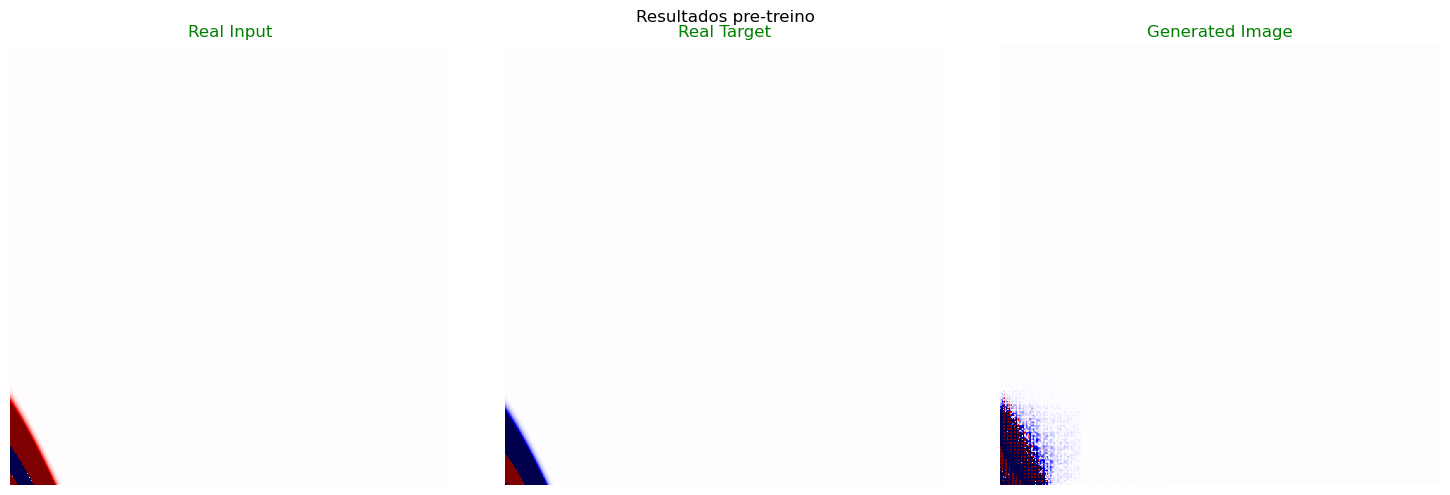

In [14]:
visualize_data(G, D, train_dl, 'Resultados pre-treino', device)

In [15]:
lr_G = 2e-4
lr_D = 2e-4
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(b1, b2))

In [16]:
n_epoches = 150
# decay_epoch = 100 # Reference paper
G_losses, D_losses, L1_losses, GAN_losses = [], [], [], []

# lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)
# lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
# lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_func)

for epoch in range(n_epoches):

    G.train()
    D.train()
    LAMBDA = 1000

    for i, (input, target) in enumerate(tqdm(train_dl)):
        it = i+1
        input, target = input.to(device), target.to(device)

        real_label = torch.ones_like(D(input, target), device=device)  # Rótulo para imagens reais
        fake_label = torch.zeros_like(D(input, target), device=device) 
        
        fake_image = G(input)
        fake_image_ = fake_image.detach()

        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode

        optimizer_G.zero_grad()

        # GAN loss, train G to make D think it's true
        loss_L1 = criterion_L1(fake_image, target)
        loss_GAN = criterion_GAN(D(input, fake_image), real_label) # Não pode usar o fake_image_ aqui, pois o gerador precisa calcular o gradiente com basse na imagem fake
        
        # G total loss
        loss_G = loss_GAN + LAMBDA * loss_L1 

        loss_G.backward()
        optimizer_G.step()

        if it % 2 == 0:
        
            """Train Discriminator """
            optimizer_D.zero_grad()
            
            loss_real = criterion_GAN(D(input, target), real_label)
            loss_fake = criterion_GAN(D(input, fake_image_), fake_label)
            loss_D = (loss_real + loss_fake) * 0.5
            
            loss_D.backward()
            optimizer_D.step()
    
    # lr_scheduler_G.step()
    # lr_scheduler_D.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    GAN_losses.append(loss_GAN.item())
    L1_losses.append(loss_L1.item())

    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | GAN: {loss_GAN.item()} L1: {loss_L1.item()}]')
    print(f'[D loss: {loss_D.item()}]')

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.85it/s]


[Epoch 1/150]
[G loss: 16.183794021606445 | GAN: 1.9168908596038818 L1: 0.014266902580857277]
[D loss: 0.17442920804023743]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.04it/s]


[Epoch 2/150]
[G loss: 4.196653366088867 | GAN: 0.8675940036773682 L1: 0.0033290591090917587]
[D loss: 0.5473096370697021]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.04it/s]


[Epoch 3/150]
[G loss: 5.650027751922607 | GAN: 2.0959296226501465 L1: 0.0035540980752557516]
[D loss: 0.7265272736549377]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.92it/s]


[Epoch 4/150]
[G loss: 5.934947967529297 | GAN: 0.3669969439506531 L1: 0.005567951127886772]
[D loss: 0.7872014045715332]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:51<00:00, 14.64it/s]


[Epoch 5/150]
[G loss: 2.6685094833374023 | GAN: 1.1259047985076904 L1: 0.001542604761198163]
[D loss: 0.6975343227386475]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.11it/s]


[Epoch 6/150]
[G loss: 4.877497673034668 | GAN: 0.6900337934494019 L1: 0.004187463782727718]
[D loss: 0.57183837890625]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.10it/s]


[Epoch 7/150]
[G loss: 6.012027263641357 | GAN: 1.1010161638259888 L1: 0.0049110110849142075]
[D loss: 0.37340736389160156]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.16it/s]


[Epoch 8/150]
[G loss: 5.00718355178833 | GAN: 1.583064317703247 L1: 0.0034241192042827606]
[D loss: 0.17115995287895203]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.94it/s]


[Epoch 9/150]
[G loss: 2.4205002784729004 | GAN: 1.407936453819275 L1: 0.001012563705444336]
[D loss: 0.32331836223602295]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.13it/s]


[Epoch 10/150]
[G loss: 9.704240798950195 | GAN: 4.872958183288574 L1: 0.004831282887607813]
[D loss: 0.028547661378979683]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.13it/s]


[Epoch 11/150]
[G loss: 6.553306579589844 | GAN: 2.832007884979248 L1: 0.003721298649907112]
[D loss: 0.8230412602424622]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.07it/s]


[Epoch 12/150]
[G loss: 8.313335418701172 | GAN: 6.156913757324219 L1: 0.0021564222406595945]
[D loss: 0.00395562406629324]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.93it/s]


[Epoch 13/150]
[G loss: 5.485706329345703 | GAN: 0.6799121499061584 L1: 0.0048057944513857365]
[D loss: 0.6811041831970215]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.04it/s]


[Epoch 14/150]
[G loss: 4.753921985626221 | GAN: 0.8702618479728699 L1: 0.0038836600724607706]
[D loss: 0.7344005107879639]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.13it/s]


[Epoch 15/150]
[G loss: 4.908504962921143 | GAN: 0.48523133993148804 L1: 0.004423273727297783]
[D loss: 0.7424451112747192]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.95it/s]


[Epoch 16/150]
[G loss: 8.10832405090332 | GAN: 4.166501998901367 L1: 0.003941821865737438]
[D loss: 0.022606944665312767]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.15it/s]


[Epoch 17/150]
[G loss: 2.2627944946289062 | GAN: 0.6922636032104492 L1: 0.0015705308178439736]
[D loss: 0.6974598169326782]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.98it/s]


[Epoch 18/150]
[G loss: 3.082685947418213 | GAN: 0.8561919927597046 L1: 0.002226493787020445]
[D loss: 0.685613751411438]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.05it/s]


[Epoch 19/150]
[G loss: 2.1545567512512207 | GAN: 0.5903652906417847 L1: 0.001564191421493888]
[D loss: 0.6716091632843018]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.76it/s]


[Epoch 20/150]
[G loss: 3.753973960876465 | GAN: 0.6540809869766235 L1: 0.0030998927541077137]
[D loss: 0.744357705116272]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.83it/s]


[Epoch 21/150]
[G loss: 7.035580635070801 | GAN: 5.166114807128906 L1: 0.0018694656901061535]
[D loss: 0.012132353149354458]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.83it/s]


[Epoch 22/150]
[G loss: 7.447789192199707 | GAN: 5.586885452270508 L1: 0.001860903576016426]
[D loss: 0.005003037396818399]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 15.00it/s]


[Epoch 23/150]
[G loss: 2.720733642578125 | GAN: 1.1719292402267456 L1: 0.0015488043427467346]
[D loss: 0.3892924189567566]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.34it/s]


[Epoch 24/150]
[G loss: 8.971384048461914 | GAN: 7.127773761749268 L1: 0.0018436107784509659]
[D loss: 0.004130932502448559]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.37it/s]


[Epoch 25/150]
[G loss: 8.66004753112793 | GAN: 6.610954284667969 L1: 0.002049093833193183]
[D loss: 0.003216228913515806]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 26/150]
[G loss: 1.3828344345092773 | GAN: 0.7712274789810181 L1: 0.0006116069271229208]
[D loss: 0.6442386507987976]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.26it/s]


[Epoch 27/150]
[G loss: 8.392633438110352 | GAN: 5.084805965423584 L1: 0.0033078272826969624]
[D loss: 0.06094823405146599]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.37it/s]


[Epoch 28/150]
[G loss: 12.882148742675781 | GAN: 8.714025497436523 L1: 0.004168123938143253]
[D loss: 0.0045930808410048485]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.35it/s]


[Epoch 29/150]
[G loss: 8.751794815063477 | GAN: 5.996632099151611 L1: 0.0027551623061299324]
[D loss: 0.0034107679966837168]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.37it/s]


[Epoch 30/150]
[G loss: 2.8870599269866943 | GAN: 0.5896444916725159 L1: 0.0022974153980612755]
[D loss: 0.6610714793205261]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.35it/s]


[Epoch 31/150]
[G loss: 7.898833274841309 | GAN: 6.404164791107178 L1: 0.001494668424129486]
[D loss: 0.3410385251045227]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.23it/s]


[Epoch 32/150]
[G loss: 10.713220596313477 | GAN: 8.082138061523438 L1: 0.002631082898005843]
[D loss: 0.0015350908506661654]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.34it/s]


[Epoch 33/150]
[G loss: 10.027412414550781 | GAN: 6.4616875648498535 L1: 0.003565724939107895]
[D loss: 0.004351236391812563]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.26it/s]


[Epoch 34/150]
[G loss: 7.278957366943359 | GAN: 4.9352126121521 L1: 0.0023437445051968098]
[D loss: 0.008052054792642593]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.36it/s]


[Epoch 35/150]
[G loss: 9.322407722473145 | GAN: 6.508495807647705 L1: 0.002813911996781826]
[D loss: 0.0037505850195884705]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.36it/s]


[Epoch 36/150]
[G loss: 2.83882212638855 | GAN: 0.45567336678504944 L1: 0.0023831487633287907]
[D loss: 0.9677783250808716]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.31it/s]


[Epoch 37/150]
[G loss: 1.7253763675689697 | GAN: 0.7064705491065979 L1: 0.0010189058957621455]
[D loss: 0.6898099184036255]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.25it/s]


[Epoch 38/150]
[G loss: 3.1617071628570557 | GAN: 0.9896907210350037 L1: 0.002172016305848956]
[D loss: 0.6268012523651123]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.27it/s]


[Epoch 39/150]
[G loss: 4.433922290802002 | GAN: 2.361518144607544 L1: 0.0020724041387438774]
[D loss: 0.10268020629882812]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.25it/s]


[Epoch 40/150]
[G loss: 8.8174467086792 | GAN: 7.141073226928711 L1: 0.001676373416557908]
[D loss: 0.0010338951833546162]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.23it/s]


[Epoch 41/150]
[G loss: 2.5200095176696777 | GAN: 0.7091546058654785 L1: 0.0018108547665178776]
[D loss: 0.6933919191360474]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.27it/s]


[Epoch 42/150]
[G loss: 8.402603149414062 | GAN: 6.839742660522461 L1: 0.001562860095873475]
[D loss: 0.009989517740905285]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.27it/s]


[Epoch 43/150]
[G loss: 12.896608352661133 | GAN: 10.017751693725586 L1: 0.0028788563795387745]
[D loss: 0.0007146464195102453]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.30it/s]


[Epoch 44/150]
[G loss: 2.066664695739746 | GAN: 0.7935290336608887 L1: 0.0012731357710435987]
[D loss: 0.6901950836181641]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.34it/s]


[Epoch 45/150]
[G loss: 2.6240668296813965 | GAN: 0.8118138313293457 L1: 0.001812252914533019]
[D loss: 0.6125495433807373]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.32it/s]


[Epoch 46/150]
[G loss: 9.223282814025879 | GAN: 6.8580403327941895 L1: 0.002365242689847946]
[D loss: 0.004243062809109688]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.33it/s]


[Epoch 47/150]
[G loss: 11.718987464904785 | GAN: 9.18407154083252 L1: 0.002534915693104267]
[D loss: 0.0024278038181364536]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.32it/s]


[Epoch 48/150]
[G loss: 9.811349868774414 | GAN: 8.313138961791992 L1: 0.0014982109423726797]
[D loss: 0.000695172231644392]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.33it/s]


[Epoch 49/150]
[G loss: 13.622526168823242 | GAN: 11.47037124633789 L1: 0.0021521553862839937]
[D loss: 0.0002511664351914078]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.29it/s]


[Epoch 50/150]
[G loss: 3.835212230682373 | GAN: 2.3949291706085205 L1: 0.0014402830274775624]
[D loss: 0.1088499203324318]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.33it/s]


[Epoch 51/150]
[G loss: 8.970720291137695 | GAN: 6.545074462890625 L1: 0.0024256459437310696]
[D loss: 0.002198167145252228]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.30it/s]


[Epoch 52/150]
[G loss: 7.944982528686523 | GAN: 6.506160736083984 L1: 0.0014388218987733126]
[D loss: 0.0022637012880295515]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.29it/s]


[Epoch 53/150]
[G loss: 8.036748886108398 | GAN: 5.98847770690918 L1: 0.002048271708190441]
[D loss: 0.003092017490416765]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.36it/s]


[Epoch 54/150]
[G loss: 8.454938888549805 | GAN: 7.0537109375 L1: 0.0014012276660650969]
[D loss: 0.0018063471652567387]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.30it/s]


[Epoch 55/150]
[G loss: 10.508094787597656 | GAN: 6.9966583251953125 L1: 0.0035114367492496967]
[D loss: 0.001443060813471675]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.30it/s]


[Epoch 56/150]
[G loss: 3.3747737407684326 | GAN: 1.2019050121307373 L1: 0.002172868698835373]
[D loss: 0.26070666313171387]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.25it/s]


[Epoch 57/150]
[G loss: 13.112510681152344 | GAN: 10.70784854888916 L1: 0.0024046620819717646]
[D loss: 0.0008255088469013572]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.30it/s]


[Epoch 58/150]
[G loss: 10.718904495239258 | GAN: 8.931241989135742 L1: 0.0017876626225188375]
[D loss: 0.0005045637371949852]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.32it/s]


[Epoch 59/150]
[G loss: 1.8875221014022827 | GAN: 0.9444978833198547 L1: 0.0009430242353118956]
[D loss: 0.6196863651275635]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.30it/s]


[Epoch 60/150]
[G loss: 6.301144123077393 | GAN: 4.393363952636719 L1: 0.0019077800679951906]
[D loss: 0.3288211226463318]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.36it/s]


[Epoch 61/150]
[G loss: 9.967363357543945 | GAN: 7.740908622741699 L1: 0.0022264542058110237]
[D loss: 0.0019486050587147474]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.29it/s]


[Epoch 62/150]
[G loss: 11.251693725585938 | GAN: 8.716447830200195 L1: 0.002535245381295681]
[D loss: 0.000984173733741045]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.36it/s]


[Epoch 63/150]
[G loss: 11.15224838256836 | GAN: 8.015386581420898 L1: 0.003136862302199006]
[D loss: 0.0018528797663748264]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.35it/s]


[Epoch 64/150]
[G loss: 13.530182838439941 | GAN: 10.594893455505371 L1: 0.0029352891724556684]
[D loss: 0.00013427740486804396]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.35it/s]


[Epoch 65/150]
[G loss: 16.534269332885742 | GAN: 13.666325569152832 L1: 0.0028679445385932922]
[D loss: 0.00019600849191192538]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.34it/s]


[Epoch 66/150]
[G loss: 8.144783020019531 | GAN: 6.430385589599609 L1: 0.0017143974546343088]
[D loss: 0.006847023963928223]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.35it/s]


[Epoch 67/150]
[G loss: 5.165571212768555 | GAN: 1.8589249849319458 L1: 0.00330664636567235]
[D loss: 1.4685732126235962]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.22it/s]


[Epoch 68/150]
[G loss: 4.921609401702881 | GAN: 2.9887402057647705 L1: 0.0019328691996634007]
[D loss: 0.07190398871898651]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.05it/s]


[Epoch 69/150]
[G loss: 8.222919464111328 | GAN: 6.583773136138916 L1: 0.0016391467070207]
[D loss: 0.0038771149702370167]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.83it/s]


[Epoch 70/150]
[G loss: 8.342823028564453 | GAN: 6.652472019195557 L1: 0.0016903507057577372]
[D loss: 0.0018386708106845617]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.02it/s]


[Epoch 71/150]
[G loss: 13.501167297363281 | GAN: 11.5065279006958 L1: 0.0019946391694247723]
[D loss: 0.0010968572460114956]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.06it/s]


[Epoch 72/150]
[G loss: 14.891965866088867 | GAN: 12.427206993103027 L1: 0.002464759163558483]
[D loss: 9.790662443265319e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.35it/s]


[Epoch 73/150]
[G loss: 2.569823741912842 | GAN: 1.0315247774124146 L1: 0.0015382989076897502]
[D loss: 0.54242342710495]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.32it/s]


[Epoch 74/150]
[G loss: 2.356818675994873 | GAN: 1.6647752523422241 L1: 0.0006920433370396495]
[D loss: 0.4008060693740845]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.34it/s]


[Epoch 75/150]
[G loss: 5.328659534454346 | GAN: 3.959897041320801 L1: 0.0013687623431906104]
[D loss: 0.019103985279798508]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.34it/s]


[Epoch 76/150]
[G loss: 10.190704345703125 | GAN: 7.259389400482178 L1: 0.0029313149861991405]
[D loss: 0.0029743188060820103]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.32it/s]


[Epoch 77/150]
[G loss: 13.348808288574219 | GAN: 10.913650512695312 L1: 0.0024351575411856174]
[D loss: 0.0008794013992883265]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.35it/s]


[Epoch 78/150]
[G loss: 10.720619201660156 | GAN: 8.359896659851074 L1: 0.0023607220500707626]
[D loss: 0.0008250648970715702]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.31it/s]


[Epoch 79/150]
[G loss: 9.127680778503418 | GAN: 6.532100677490234 L1: 0.00259558018296957]
[D loss: 0.005596828646957874]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.32it/s]


[Epoch 80/150]
[G loss: 11.56644344329834 | GAN: 9.152705192565918 L1: 0.0024137385189533234]
[D loss: 0.0018145379144698381]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.27it/s]


[Epoch 81/150]
[G loss: 5.520345687866211 | GAN: 4.579122066497803 L1: 0.0009412238723598421]
[D loss: 0.009499593637883663]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.21it/s]


[Epoch 82/150]
[G loss: 6.823616981506348 | GAN: 4.658167362213135 L1: 0.0021654493175446987]
[D loss: 0.0417485348880291]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.32it/s]


[Epoch 83/150]
[G loss: 14.626957893371582 | GAN: 12.052535057067871 L1: 0.0025744226295500994]
[D loss: 0.0007787600043229759]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.35it/s]


[Epoch 84/150]
[G loss: 3.7262015342712402 | GAN: 2.199948310852051 L1: 0.0015262531815096736]
[D loss: 0.48593270778656006]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.22it/s]


[Epoch 85/150]
[G loss: 3.3535571098327637 | GAN: 1.326343059539795 L1: 0.002027214039117098]
[D loss: 1.037700891494751]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.97it/s]


[Epoch 86/150]
[G loss: 9.766155242919922 | GAN: 7.691130638122559 L1: 0.0020750246476382017]
[D loss: 0.001496342127211392]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.89it/s]


[Epoch 87/150]
[G loss: 11.29334831237793 | GAN: 9.637166023254395 L1: 0.0016561825759708881]
[D loss: 0.00044677749974653125]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.92it/s]


[Epoch 88/150]
[G loss: 4.328269004821777 | GAN: 2.653162956237793 L1: 0.0016751062357798219]
[D loss: 0.11216341704130173]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.94it/s]


[Epoch 89/150]
[G loss: 13.057321548461914 | GAN: 10.78598403930664 L1: 0.0022713374346494675]
[D loss: 0.0008352463482879102]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.08it/s]


[Epoch 90/150]
[G loss: 5.845489025115967 | GAN: 3.831822395324707 L1: 0.002013666555285454]
[D loss: 0.024954358115792274]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.03it/s]


[Epoch 91/150]
[G loss: 7.133335113525391 | GAN: 5.0050811767578125 L1: 0.0021282541565597057]
[D loss: 0.00564084155485034]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.87it/s]


[Epoch 92/150]
[G loss: 9.235905647277832 | GAN: 7.01617431640625 L1: 0.0022197312209755182]
[D loss: 0.001334248692728579]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.01it/s]


[Epoch 93/150]
[G loss: 7.8993635177612305 | GAN: 6.202115058898926 L1: 0.001697248313575983]
[D loss: 0.009429777041077614]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.09it/s]


[Epoch 94/150]
[G loss: 9.827951431274414 | GAN: 6.889501571655273 L1: 0.0029384498484432697]
[D loss: 0.002145350445061922]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.97it/s]


[Epoch 95/150]
[G loss: 13.916433334350586 | GAN: 10.953543663024902 L1: 0.002962889149785042]
[D loss: 0.00024375994689762592]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.21it/s]


[Epoch 96/150]
[G loss: 12.373451232910156 | GAN: 9.456816673278809 L1: 0.0029166345484554768]
[D loss: 0.00039409296005032957]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 97/150]
[G loss: 10.8853759765625 | GAN: 8.146872520446777 L1: 0.002738503972068429]
[D loss: 0.0005893875495530665]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 98/150]
[G loss: 14.681602478027344 | GAN: 11.664642333984375 L1: 0.0030169603414833546]
[D loss: 0.0002575405815150589]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 99/150]
[G loss: 9.650837898254395 | GAN: 7.0586957931518555 L1: 0.002592142205685377]
[D loss: 0.01775435544550419]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 100/150]
[G loss: 8.755536079406738 | GAN: 6.695845603942871 L1: 0.0020596906542778015]
[D loss: 0.002196445595473051]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 101/150]
[G loss: 10.213335990905762 | GAN: 8.39604377746582 L1: 0.0018172918353229761]
[D loss: 0.0023225850891321898]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 102/150]
[G loss: 10.129515647888184 | GAN: 7.152126789093018 L1: 0.0029773886781185865]
[D loss: 0.0016790947411209345]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 103/150]
[G loss: 12.759485244750977 | GAN: 10.091521263122559 L1: 0.0026679644361138344]
[D loss: 0.0002800436341203749]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 104/150]
[G loss: 11.306671142578125 | GAN: 8.748589515686035 L1: 0.00255808187648654]
[D loss: 0.0006215723697096109]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 105/150]
[G loss: 8.607666969299316 | GAN: 7.030741214752197 L1: 0.0015769257443025708]
[D loss: 0.003576054936274886]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.37it/s]


[Epoch 106/150]
[G loss: 11.397698402404785 | GAN: 9.145709991455078 L1: 0.0022519882768392563]
[D loss: 0.001196118420921266]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 107/150]
[G loss: 12.130722045898438 | GAN: 9.158580780029297 L1: 0.0029721406754106283]
[D loss: 0.0005196391139179468]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 108/150]
[G loss: 11.671930313110352 | GAN: 9.213266372680664 L1: 0.0024586638901382685]
[D loss: 0.00024108857905957848]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 109/150]
[G loss: 1.7046229839324951 | GAN: 0.44054585695266724 L1: 0.0012640771456062794]
[D loss: 1.1066417694091797]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 110/150]
[G loss: 9.91800308227539 | GAN: 7.99536657333374 L1: 0.001922636991366744]
[D loss: 0.0008209159132093191]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 111/150]
[G loss: 12.297250747680664 | GAN: 8.706367492675781 L1: 0.0035908829886466265]
[D loss: 0.0007340521551668644]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 112/150]
[G loss: 13.810596466064453 | GAN: 11.086080551147461 L1: 0.002724515739828348]
[D loss: 0.00020343298092484474]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 113/150]
[G loss: 5.529260635375977 | GAN: 4.528456211090088 L1: 0.0010008044773712754]
[D loss: 0.02010800689458847]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 114/150]
[G loss: 8.798663139343262 | GAN: 5.7496209144592285 L1: 0.0030490420758724213]
[D loss: 0.0036904255393892527]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 115/150]
[G loss: 10.396608352661133 | GAN: 7.557359218597412 L1: 0.0028392495587468147]
[D loss: 0.0009049325599335134]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 116/150]
[G loss: 11.569948196411133 | GAN: 9.577795028686523 L1: 0.0019921527709811926]
[D loss: 0.0005819812067784369]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 117/150]
[G loss: 9.912073135375977 | GAN: 8.267224311828613 L1: 0.0016448487294837832]
[D loss: 0.0005149478674866259]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 118/150]
[G loss: 12.116397857666016 | GAN: 8.82310676574707 L1: 0.0032932916656136513]
[D loss: 0.00026295529096387327]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 119/150]
[G loss: 11.993629455566406 | GAN: 9.70445442199707 L1: 0.0022891745902597904]
[D loss: 0.000305148889310658]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 120/150]
[G loss: 13.588338851928711 | GAN: 11.283939361572266 L1: 0.0023043998517096043]
[D loss: 6.048251816537231e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 121/150]
[G loss: 13.991695404052734 | GAN: 9.69424057006836 L1: 0.004297454375773668]
[D loss: 0.00021168467355892062]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 122/150]
[G loss: 15.200469017028809 | GAN: 10.950182914733887 L1: 0.0042502861469984055]
[D loss: 0.00010461061174282804]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 123/150]
[G loss: 15.718411445617676 | GAN: 11.608797073364258 L1: 0.0041096145287156105]
[D loss: 3.024011675734073e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 124/150]
[G loss: 17.18314552307129 | GAN: 14.473641395568848 L1: 0.0027095037512481213]
[D loss: 2.046955887635704e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 125/150]
[G loss: 3.467709541320801 | GAN: 1.390853762626648 L1: 0.0020768556278198957]
[D loss: 0.46727263927459717]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 126/150]
[G loss: 8.105154991149902 | GAN: 6.581161022186279 L1: 0.0015239937929436564]
[D loss: 0.0018914800602942705]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 127/150]
[G loss: 11.226051330566406 | GAN: 8.886970520019531 L1: 0.002339080674573779]
[D loss: 0.0004204854485578835]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 128/150]
[G loss: 8.888882637023926 | GAN: 6.870461940765381 L1: 0.002018420957028866]
[D loss: 0.0010067541152238846]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 129/150]
[G loss: 9.819025039672852 | GAN: 6.775940895080566 L1: 0.003043083706870675]
[D loss: 0.0020384478848427534]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 130/150]
[G loss: 9.188552856445312 | GAN: 7.629745960235596 L1: 0.001558807329274714]
[D loss: 0.0007545969565398991]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 131/150]
[G loss: 11.114507675170898 | GAN: 9.141341209411621 L1: 0.001973166596144438]
[D loss: 0.00047072989400476217]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 132/150]
[G loss: 4.986867427825928 | GAN: 2.7100043296813965 L1: 0.0022768632043153048]
[D loss: 1.0145567655563354]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 133/150]
[G loss: 11.403426170349121 | GAN: 8.40870475769043 L1: 0.002994721755385399]
[D loss: 0.001580572221428156]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 134/150]
[G loss: 9.204038619995117 | GAN: 7.2320356369018555 L1: 0.0019720031414180994]
[D loss: 0.0015876716934144497]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 135/150]
[G loss: 8.588956832885742 | GAN: 6.830345153808594 L1: 0.0017586115282028913]
[D loss: 0.0027371186297386885]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 136/150]
[G loss: 10.101256370544434 | GAN: 7.670687675476074 L1: 0.002430568914860487]
[D loss: 0.0005840621888637543]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 137/150]
[G loss: 8.305780410766602 | GAN: 6.345750331878662 L1: 0.0019600295927375555]
[D loss: 0.0018458543345332146]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 138/150]
[G loss: 5.738536357879639 | GAN: 3.8259942531585693 L1: 0.001912542269565165]
[D loss: 0.2557051181793213]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 139/150]
[G loss: 9.819342613220215 | GAN: 7.638315200805664 L1: 0.002181027317419648]
[D loss: 0.0006423522718250751]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 140/150]
[G loss: 10.65352725982666 | GAN: 8.4459810256958 L1: 0.002207546029239893]
[D loss: 0.0006398145342245698]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 141/150]
[G loss: 9.587835311889648 | GAN: 7.4038777351379395 L1: 0.002183957025408745]
[D loss: 0.001351298182271421]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 142/150]
[G loss: 10.672140121459961 | GAN: 7.751447677612305 L1: 0.0029206923209130764]
[D loss: 0.000568049552384764]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 143/150]
[G loss: 4.2139811515808105 | GAN: 2.0065054893493652 L1: 0.0022074757143855095]
[D loss: 0.37985432147979736]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 144/150]
[G loss: 6.967710494995117 | GAN: 5.668846130371094 L1: 0.001298864372074604]
[D loss: 0.004427730571478605]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 145/150]
[G loss: 2.3145546913146973 | GAN: 1.0690679550170898 L1: 0.0012454867828637362]
[D loss: 0.5635372400283813]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.30it/s]


[Epoch 146/150]
[G loss: 7.461889266967773 | GAN: 5.537010669708252 L1: 0.001924878335557878]
[D loss: 0.006514678243547678]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.37it/s]


[Epoch 147/150]
[G loss: 8.06356143951416 | GAN: 7.279147624969482 L1: 0.000784413714427501]
[D loss: 0.0014459893573075533]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 148/150]
[G loss: 9.909049987792969 | GAN: 8.093505859375 L1: 0.0018155444413423538]
[D loss: 0.0009752202895469964]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.39it/s]


[Epoch 149/150]
[G loss: 10.437450408935547 | GAN: 8.165888786315918 L1: 0.00227156188338995]
[D loss: 0.0006167125538922846]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.38it/s]


[Epoch 150/150]
[G loss: 8.415895462036133 | GAN: 7.020675182342529 L1: 0.0013952200533822179]
[D loss: 0.0017644220497459173]


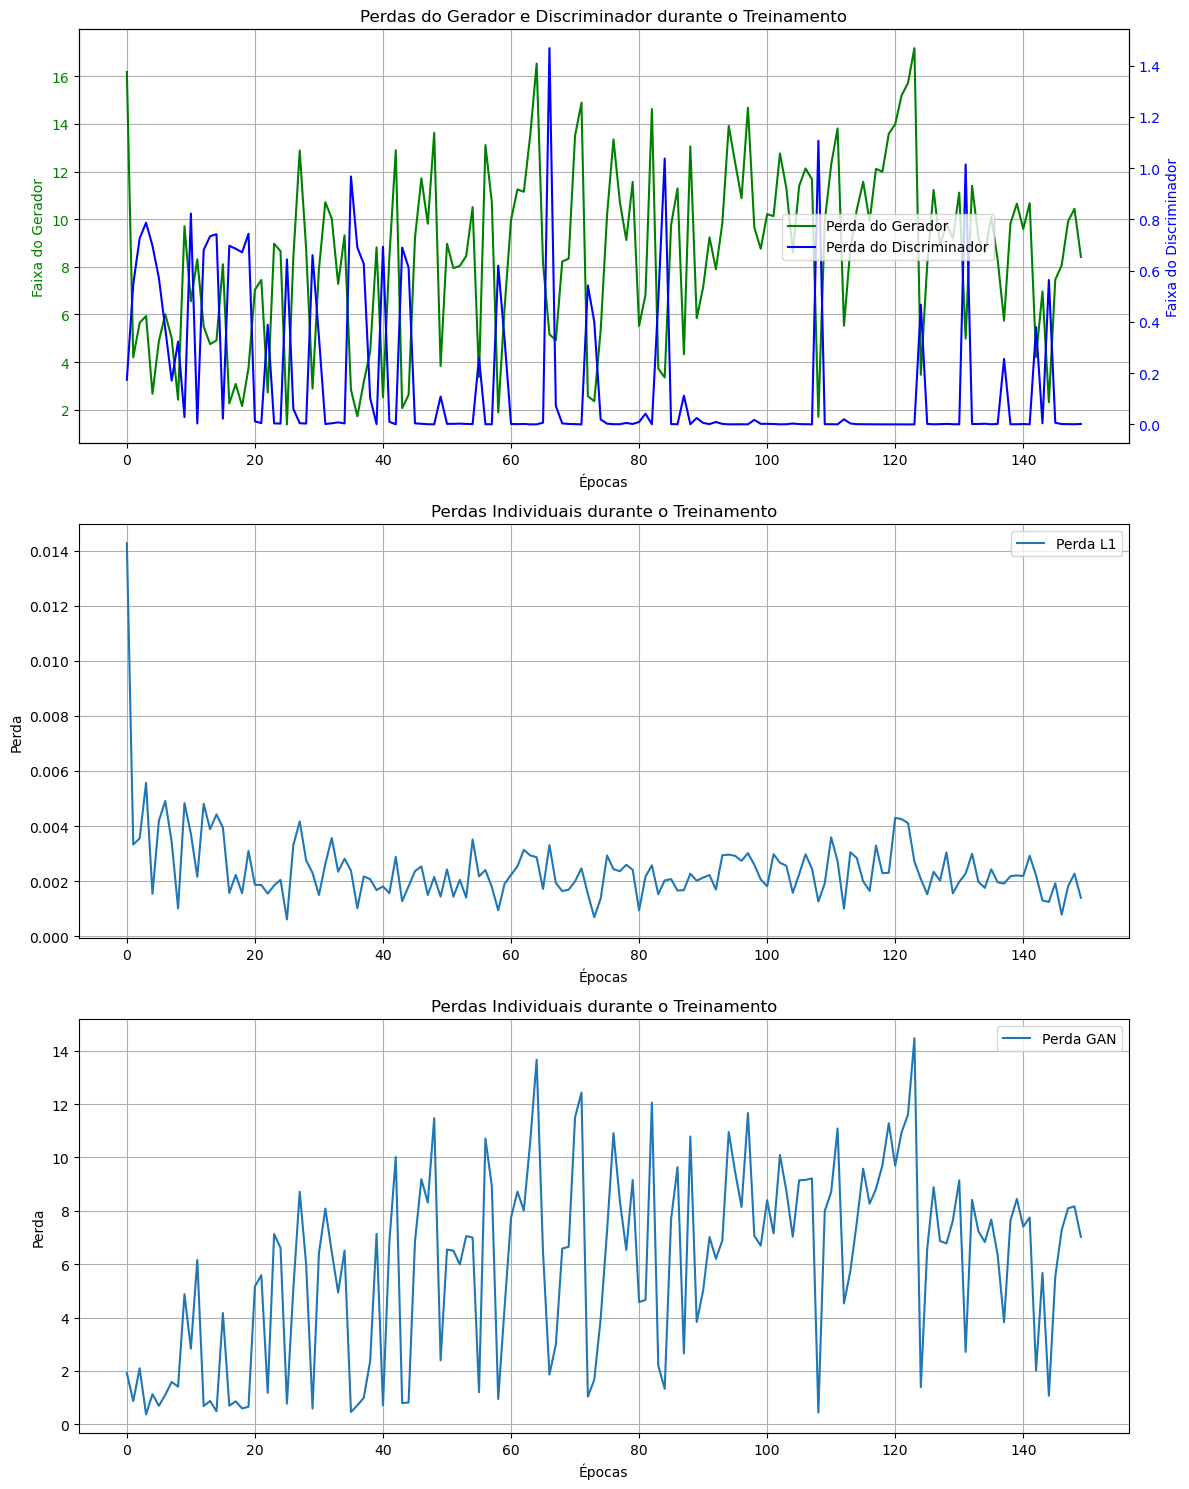

In [17]:
fig, (ax1, ax3, ax4) = plt.subplots(3,1, figsize=(12, 15))  # Definindo um layout de 1 linha e 2 colunas

# Primeiro gráfico: Perdas do Gerador e Discriminador
ax1.plot(G_losses, 'g-', label="Perda do Gerador")
ax1.set_xlabel("Épocas")
ax1.set_ylabel('Faixa do Gerador', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.plot(D_losses, 'b-', label="Perda do Discriminador")
ax2.set_ylabel('Faixa do Discriminador', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perdas do Gerador e Discriminador durante o Treinamento")
ax1.grid()
fig.legend(loc='upper left',  bbox_to_anchor=(0.65, 0.858))

# Segundo gráfico: Perdas Individuais durante o Treinamento
ax3.plot(L1_losses, label="Perda L1")
ax3.set_xlabel("Épocas")
ax3.set_ylabel("Perda")
ax3.set_title("Perdas Individuais durante o Treinamento")
ax3.grid()
ax3.legend()

ax4.plot(GAN_losses, label="Perda GAN")
ax4.set_xlabel("Épocas")
ax4.set_ylabel("Perda")
ax4.set_title("Perdas Individuais durante o Treinamento")
ax4.grid()
ax4.legend()

# Salvando os gráficos
plt.tight_layout()  # Ajusta automaticamente o espaçamento
plt.savefig('pix2pix_P2VZ_Loss_V3.png')
plt.show()

In [18]:
torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'generator_optimizer_state_dict': optimizer_G.state_dict(),
    'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
    'epoch': epoch
}, 'pix2pix_P2VZcheckpoint_V3.pth')

checkpoint = torch.load('pix2pix_P2VZcheckpoint_V3.pth', weights_only=True)